# Vision on OCT2017
Inspired by: [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

Dataset: [Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2)


This project stemmed from my curiosity to learn the following things:
- Vision Transformers (ViT) & Attention Mechanisms
- Interpreting and Implementing Architecture from papers

And the big question:
> *How do I know what my Vision model is looking at the right thing and not just the corner of a screen?*

**NOTE:** The goal of this notebook is to train models and interpret their "vision". I've not evaluated or compared how they performed against each other, but it would be straight forward to do. The key takeaway from this notebook is understanding how different models worked and how to interpret them in some way. 

## The Quest for Explanability & Interpretability
> *This has led me down a rabbit hole of understanding explainable and interpretable AI...How would clinicians be confident in what our models are telling them if we don't know ourselves?*

None of the ML and Computer Vision courses I took taught this explicitly. Some were sort of obvious, for example projections of hyperdimensional space (PCA and the likes) can show us how datapoints are grouped together, but others not so much. 

I recall running a janky CNN to classify MNIST for the first time. It was magical to watch and understand how the math and computations work behind the scene -- **but** I did not understand how it worked exactly. Sure, I knew enough to say that we're "embedding 'features' as part of the weights", but unlike conventional filters like edge detectors, these "features" are learned through training and not always intuitive. This has led me down a rabbit hole of understanding explainable and interpretable AI.

I realized this is becoming an increasingly important discussion in the applications of AI in the Biomedical space. How can clinicians be confident in what our models are telling them if we don't know ourselves? Fortunately, there are methods to "see" what these models are doing and more are being developed every day. 

What I find truly impactful through this mini study is that while models that can predict are exciting, showing how a model is "thinking" is what will bring us closer to adoption. A model does not always need to be the solution but it *can* also be a supporting player in healthcare; imagine: a model provides a cancer diagnosis and prognosis and shows the reasoning behind its judgement, then a human clinician verifies and uses all other factors and their experience to guide the final decision.

## Final Reflections
What began as a curiosity about what my model is looking at has evolved into deeper questions: how can we design interpretable and trustworthy vision architectures that are not only accurate? This is the question I hope to carry forward into graduate research, building on methods like Grad-CAM and attention visualization while exploring new approaches to explainability in biomedical imaging.

This is what I'm excites me most now: *Explainable AI in Healthcare*.

## Resources I learned from:
- [Deep Learning Tutorials by Phillip Lippe @ UvA](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html)
- [Attention is All You Need (Vaswani et al., 2017)](https://arxiv.org/html/1706.03762v7)
- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/abs/2010.11929)
- [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization (Selvaraju et al., 2017)](https://arxiv.org/pdf/1610.02391)

Other Resources to credit:
- YouTube and StackOverflow
- ChatGPT for when I got lost

## Future Work:
- Evaluating the models and consider hyperparmeter optimization
- Some of the accuracy values seem pretty high suggesting overfitting -- I'd like to learn how medical models are selected.
- Explore other vision models and their interpretability? 
- Explore other visualization tools
    - [LeGrad](https://walidbousselham.com/LeGrad/)
    - [Vit-ReciproCAM](https://arxiv.org/pdf/2310.02588)

\- *Alvin*

In [1]:
import os
import copy

import torch
import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from main import VIT_CONFIG, RESNET_SCRATCH_CONFIG, RESNET_FINETUNED_CONFIG
from trainers import *
from models import *
from preprocessing import *

# Data Loading
Created the dataloaders and patchify functions required for ViT.

In [2]:
# dataloaders = get_data_loaders()
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(RESNET_NORM_MEAN, RESNET_NORM_STD),
    ]
)

compare_dataset = datasets.ImageFolder(os.path.join("data", "compare"), transform=transform)

dataloader = torch.utils.data.DataLoader(
        compare_dataset, batch_size=4, num_workers=4
)

test_dl = copy.deepcopy(dataloader) # deep copy to not confound the actual loaders for later

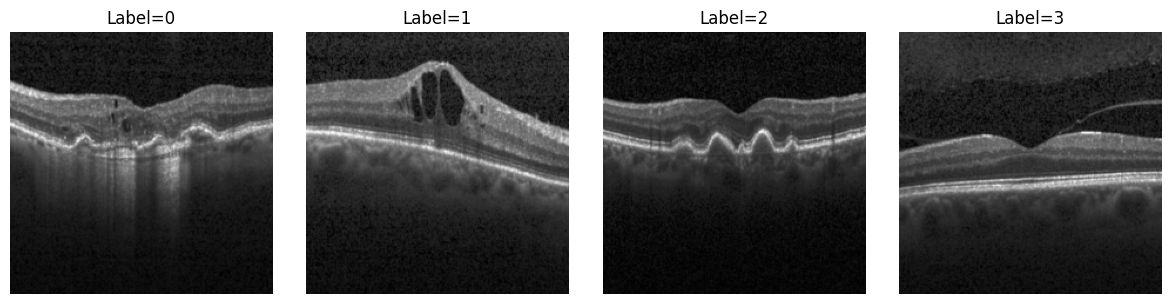

In [3]:
with torch.no_grad():
    for img, labels in test_dl:
        img, labels = img.to("cuda"), labels.to("cuda")
        break  # only take first batch
        
batch_size = img.size(0)
fig, axes = plt.subplots(1, batch_size, figsize=(3*batch_size, 3))

for i in range(batch_size):
    np_img = denormalize(img[i])
    axes[i].imshow(np_img)
    axes[i].set_title(f"Label={labels[i].item()}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

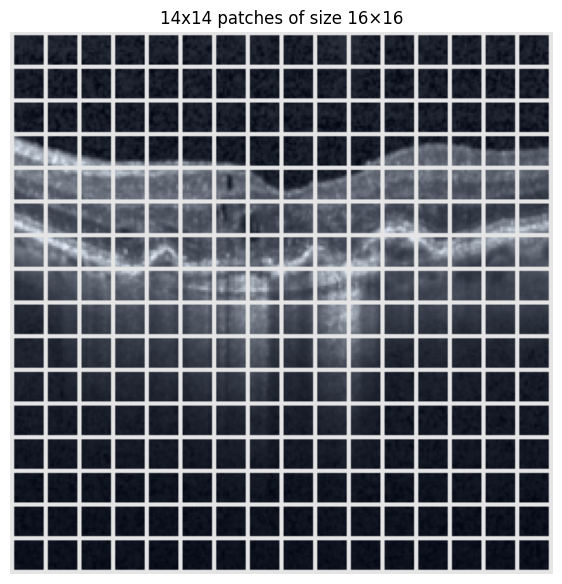

In [4]:
# assume input images are [B, 3, 224, 224]
patch_size = 14
stack, label = next(iter(test_dl))
patches = patchify(stack, patch_size=patch_size, flatten=False)  # [n_batches, batch_size, channels, patch_size, patch_size]

# show patches of the first image
img_patches = patches[0] 

# make a 4x4 grid
grid = torchvision.utils.make_grid(img_patches, nrow=16, normalize=True, pad_value=0.9)
grid = grid.permute(1, 2, 0)  # CHW -> HWC

plt.figure(figsize=(7,124))
plt.imshow(grid)
plt.axis("off")
plt.title("14x14 patches of size 16×16")
plt.show()

# Visualizations
In this section, we explore training dynamics and visualizations that help interpret what the models are "looking at."

I trained:
- Two ResNet50-based classifiers (one from scratch, one fine-tuned from pretrained weights)
- A ViT-based classifier (from scratch)

The ResNet models converged faster, while the ViT required more epochs and patience. With more time, I would extend ViT training further, but the results here already illustrate interesting differences.

## Grad-CAM
Grad-CAM (Selvaraju et al., 2017) is a technique for generating activation heatmaps by using the gradients of models' layers. In practice, Grad-CAM highlights *which regions of an input image contributed most* to a model’s prediction. This provides an interpretable visualization of the model’s focus.

### ResNet50
For both ResNet models, the Grad-CAM heatmaps showed a convincing alignment with retinal interfaces which intuitively makes sense as these layers are where pathological changes are likely to manifest.  

This suggests that the CNNs learned feature representations that overlap with clinically relevant regions. These generally aligned with the occlusion testing on models originally trained by [Kermany et al. (2018)](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) on the same dataset. It was reassuring to see that the highlighted regions were not random but consistent with areas a human expert might also examine.

### ViT
For the ViT, I extracted gradients from the first normalization layer in the last transformer encoder block (a common choice for CAM methods). Despite achieving reasonable validation accuracy, the resulting Grad-CAMs were less localized than ResNet’s.  

In some cases (e.g., aggressive disease examples), the ViT activations spanned large portions of the image, suggesting that the model was leveraging global context. In others, attention still centered on retinal interfaces, though less sharply than in the CNNs. I do also note that the model does focus some attention to empty white locations of the cropped images.

Follow-up questions: are the broader heatmaps a sign of ViT looking at the entire visual context or an artifact of my Grad-CAM implementation? 

I believe I adapted the procedure from the Grad-CAM repository correctly, but further experiments (e.g., using alternative interpretability methods like ReciproCAM or Attention Rollout) could help clarify this. Maybe even further training would help too.

In [5]:
def generate_cam_compare(img, labels, preds, model, target_layers, targets=None, reshape=None):
    batch_size = img.size(0)
    vis_group_size = min(4, batch_size)
    fig, axes = plt.subplots(2, vis_group_size, figsize=(10, 4))
    norm_imgs = []

    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape)
    grayscale_cam = cam(input_tensor=img, targets=targets)
    
    for i in range(vis_group_size):
        np_img = denormalize(img[i])
        norm_imgs.append(np_img)
        axes[0][i].imshow(np_img)
        axes[0][i].set_title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
        axes[0][i].axis("off")
        viz = show_cam_on_image(norm_imgs[i], grayscale_cam[i, :])
   
        axes[1][i].imshow(viz)
        axes[1][i].axis("off")

    fig.tight_layout()
    return fig, axes

def plot_eval_curves(df):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(df["Epoch"], df["train_loss"], label="train")
    axes[0].plot(df["Epoch"], df["val_loss"], label="val")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Error")
    axes[0].set_title("Accuracy vs Epoch")
    axes[0].grid(alpha=0.5)
    axes[0].legend()
    
    axes[1].plot(df["Epoch"], df["train_acc"], label="train")
    axes[1].plot(df["Epoch"], df["val_acc"], label="val")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Acccuracy vs Epoch")
    axes[1].legend()
    axes[1].grid(alpha=0.5)
    
    return fig, axes

def process_logs(logpath):
    # @Josh [https://stackoverflow.com/questions/78359357/pytorch-lightning-csvlogger-why-are-training-and-validation-losses-on-different]
    df = pd.read_csv(logpath)
    df = df.groupby('epoch').mean()  # merge the train and valid rows
    df['Epoch'] = df.index  # because "Epoch" gets turned into the index
    df.index.name = ''  # to remove the name "Epoch" from the index
    df = df.dropna(axis=1)
    return df

## Trained ResNet50

In [6]:
scratch_df = process_logs("logs/resnet-scratch/version_2/metrics.csv")
scratch_df.head()

,step,train_acc,train_loss,val_acc,val_loss,Epoch
,,,,,,
0.0,8348.0,0.502330,0.856194,0.8750,0.366370,0.0
1.0,16697.0,0.721335,0.513632,0.9750,0.057292,1.0
2.0,25046.0,0.771302,0.430226,0.9125,0.285636,2.0
3.0,33395.0,0.795290,0.388583,0.9875,0.043234,3.0
4.0,41744.0,0.806487,0.365411,0.9500,0.207133,4.0


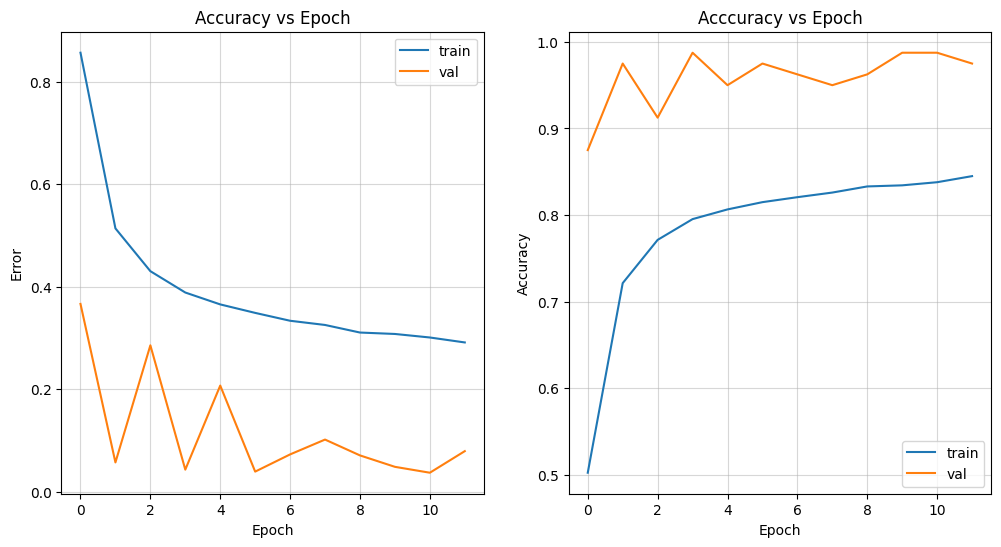

In [7]:
fig, ax = plot_eval_curves(scratch_df)

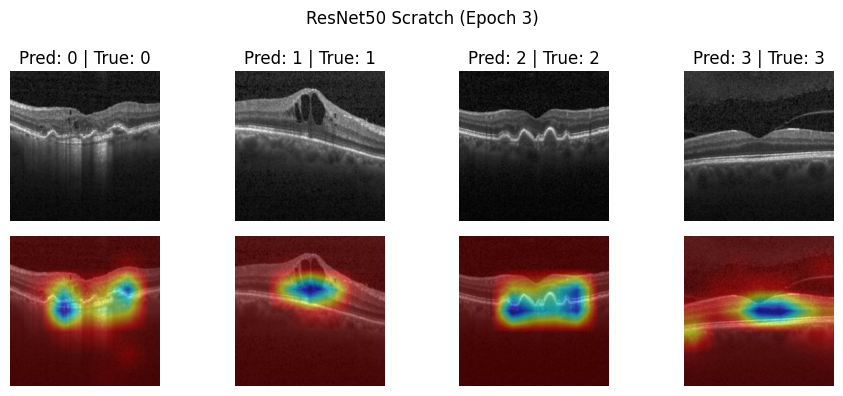

In [8]:
model = ResNetClassifier.load_from_checkpoint(r"checkpoints\resnet-scratch\epoch=3-val_acc=0.99.ckpt", cfg=RESNET_SCRATCH_CONFIG)

model.eval().to("cuda")

with torch.no_grad():
    # for img, labels in dataloaders["test"]:
    for img, labels in dataloader:
        img, labels = img.to("cuda"), labels.to("cuda")
        logits = model(img)
        preds = torch.argmax(logits, dim=1)
        break  # only take first batch
        
target_layers = [model.backbone.layer4[-1]]
fig, ax = generate_cam_compare(
    img, labels, preds, model, target_layers
)

fig.suptitle("ResNet50 Scratch (Epoch 3)")
fig.tight_layout()

## Finetuned ResNet50

In [9]:
finetuned_df = process_logs("logs/resnet-tuned/version_0/metrics.csv")
finetuned_df.head()

,step,train_acc,train_loss,val_acc,val_loss,Epoch
,,,,,,
0.0,8348.0,0.594659,0.974595,0.8500,0.477344,0.0
1.0,16697.0,0.605616,0.994265,0.8375,0.411376,1.0
2.0,25046.0,0.609351,0.975923,0.9000,0.324780,2.0
3.0,33395.0,0.606874,0.981632,0.8625,0.403069,3.0
4.0,41744.0,0.609405,0.966062,0.8375,0.371289,4.0


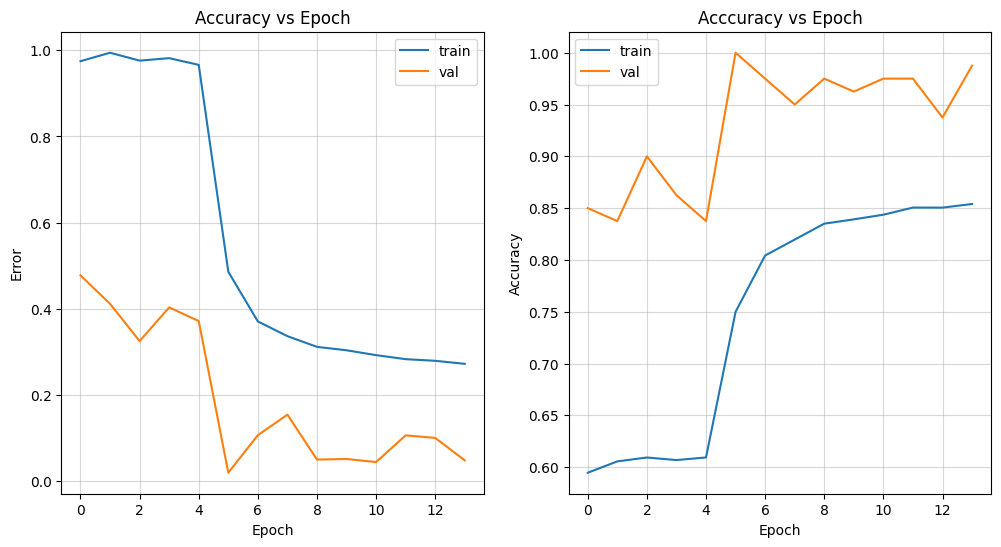

In [10]:
fig, ax = plot_eval_curves(finetuned_df)

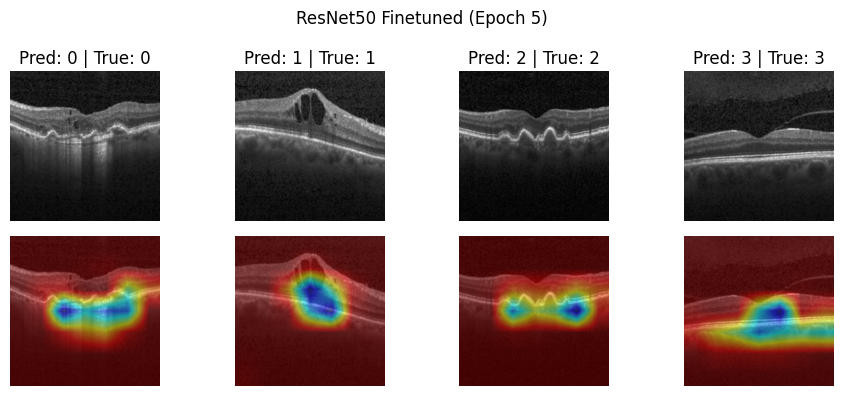

In [11]:
model = ResNetClassifier.load_from_checkpoint(r"checkpoints\resnet-tuned\epoch=5-val_acc=1.00.ckpt", cfg=RESNET_SCRATCH_CONFIG)

model.eval().to("cuda")

with torch.no_grad():
    # for img, labels in dataloaders["test"]:
    for img, labels in dataloader:
        img, labels = img.to("cuda"), labels.to("cuda")
        logits = model(img)
        preds = torch.argmax(logits, dim=1)
        break  # only take first batch
        
target_layers = [model.backbone.layer4[-1]]
fig, ax = generate_cam_compare(
    img, labels, preds, model, target_layers
)
fig.suptitle("ResNet50 Finetuned (Epoch 5)")
fig.tight_layout()

# 'Homemade' ViT Classifier
Note that training stopped and we started retraining from the best classifier at least twice.

In [12]:
vit_df = pd.concat([
    process_logs(f"logs/ViT/version_{i}/metrics.csv")
    for i in [5,6,7]
])
vit_df = vit_df.reset_index()
vit_df["Epoch"] = vit_df.index

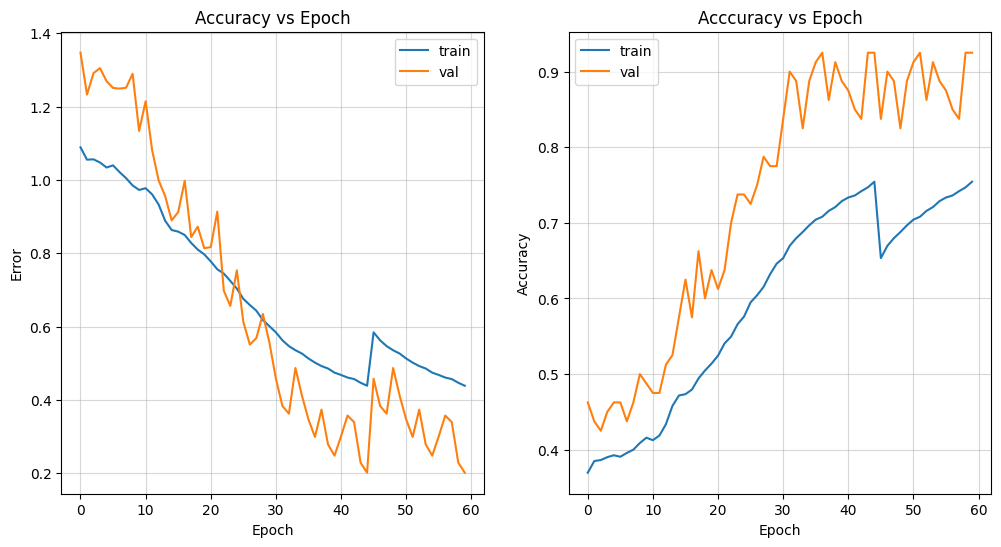

In [13]:
fig, ax = plot_eval_curves(vit_df)

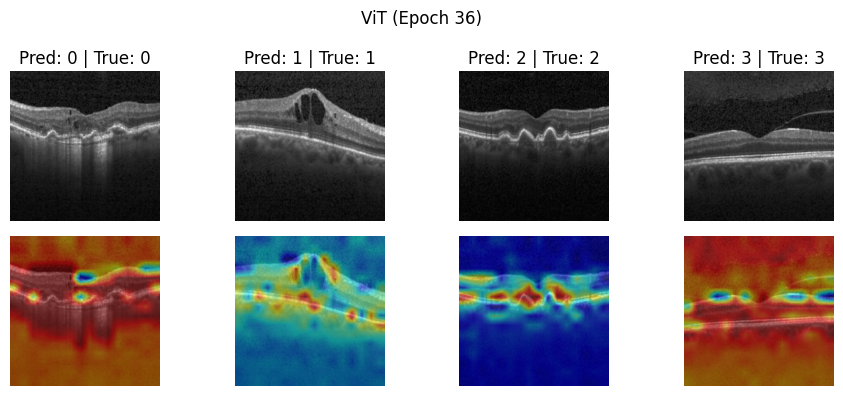

In [14]:
model = ViT.load_from_checkpoint(r"checkpoints\ViT\epoch=6-val_acc=0.92-v1.ckpt", cfg=VIT_CONFIG)

with torch.no_grad():
    # for img, labels in dataloaders["test"]:
    for img, labels in dataloader:
        img, labels = img.to("cuda"), labels.to("cuda")
        logits = model(img)
        preds = torch.argmax(logits, dim=1)
        break  # only take first batch


target_layers = [model.model.enctrans[-1].layer_norm_1]

def reshape_transform(tensor, height=16, width=16):
    """Adapted from PyTorch Grad CAM's 
    github page `reshape_transforms.py`
    """
    # print(tensor.shape) [T, B, C]
    tensor = tensor.permute(1, 0, 2) # [B, T, C]
    result = tensor[:, 1:, :].reshape(
        tensor.size(0), height, width, tensor.size(2)
    ) 
    # print(result.shape)
    # print(result.shape)
    result = result.transpose(1, 3).transpose(2, 3)
    return result

fig, ax = generate_cam_compare(
    img, labels, preds, model.model, target_layers,
    reshape=reshape_transform
)
fig.suptitle("ViT (Epoch 36)")
fig.tight_layout()